In [51]:
import sys
import math

import torch
import numpy as np
import matplotlib.pyplot as plt
import dsdl
import gpytorch
import tqdm


from torcheval.metrics import BinaryAUROC

sys.path.append("..")

from src._97_gpytorch import LogisticGPVI, GPModel, LogitLikelihood, PGLikelihood

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
data = dsdl.load("cod-rna")

In [44]:
np.random.seed(1)

X, y = data.get_train()
X = X.todense()

X = torch.tensor(X, dtype=torch.float)
Xstd = X.std(dim=0)
Xmean = X.mean(dim=0)
X = (X - Xmean) / Xstd
y = torch.tensor(y, dtype=torch.float)
y[y == -1] = 0


X_test, y_test = data.get_test()
X_test = X_test.todense()
y_test[y_test == -1] = 0

n_test = 2500
id0 = np.random.choice(np.where(y_test == 0)[0], n_test, replace=False)
id1 = np.random.choice(np.where(y_test == 1)[0], n_test, replace=False)

X_test = np.concatenate((X_test[id0, :], X_test[id1, :]), axis=0)
y_test = np.concatenate((y_test[id0], y_test[id1]), axis=0)

X_test = torch.tensor(X_test, dtype=torch.float)
X_test = (X_test - Xmean) / Xstd
y_test = torch.tensor(y_test, dtype=torch.float)

In [64]:
f0 = LogisticGPVI(y, X, n_inducing=20, n_iter=12, use_loader=True, verbose=False)
f0.fit()
f0.runtime

27.2462739944458

In [65]:
f1 = LogisticGPVI(y, X, likelihood=PGLikelihood(), n_inducing=20, n_iter=12, use_loader=True, verbose=False)
f1.fit()
f1.runtime

30.906986474990845

In [66]:
y_pred = f0.predict(X_test)

auc = BinaryAUROC()
auc.update(y_test, y_pred)
print(auc.compute())

tensor(0.9157, dtype=torch.float64)


In [67]:
y_pred = f1.predict(X_test)

auc = BinaryAUROC()
auc.update(y_test, y_pred)
print(auc.compute())

tensor(0.8855, dtype=torch.float64)


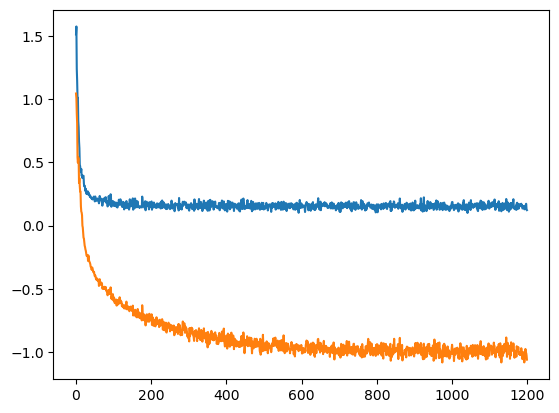

In [68]:
plt.plot(f0.loss)
plt.plot(f1.loss)

In [69]:
# means = f.model(X_test).mean
lower, upper = f0.credible_intervals(X_test)
print( (upper - lower).mean() )

lower, upper = f1.credible_intervals(X_test)
print( (upper - lower).mean() )

tensor(1.4100)
tensor(0.1019)


# Uncertainty matters

(-6.0, 6.0)

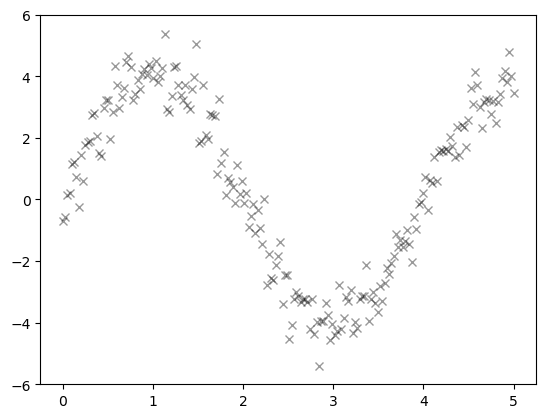

In [79]:
torch.manual_seed(0)

n = 200
train_x = torch.linspace(0, 5, n)
train_f = torch.sin(train_x * (0.5 * math.pi)) * 4 + math.sqrt(0.4) * torch.randn(n)
train_x = train_x.reshape(-1, 1)

train_p = torch.sigmoid(train_f)
train_y = torch.bernoulli(train_p)

plt.plot(train_x.detach().numpy(), train_f.detach().numpy(), 'xk', alpha=0.4)
plt.ylim(-6, 6)

In [80]:
likelihood = LogitLikelihood(l_max=12)
f0 = LogisticGPVI(train_y, train_x, likelihood=likelihood, n_inducing=50, 
                 n_iter=300, thresh=1e-4, use_loader=False, verbose=False)
f0.fit()
f0.runtime

7.299006223678589

In [88]:
likelihood = PGLikelihood()
f1 = LogisticGPVI(train_y, train_x, likelihood=likelihood, n_inducing=50,
                    n_iter=300, thresh=1e-5, use_loader=False, verbose=False)
f1.fit()
f1.runtime

6.499026536941528

In [89]:
test_x = torch.linspace(0, 5, 100).reshape(-1, 1)

f0_lower, f0_upper = f0.credible_intervals(test_x)
f0_pred = f0.model(test_x).mean
print( (f0_upper - f0_lower).mean() )


f1_lower, f1_upper = f1.credible_intervals(test_x)
f1_pred = f1.model(test_x).mean
print( (f1_upper - f1_lower).mean() )

tensor(2.6170)
tensor(1.7850)


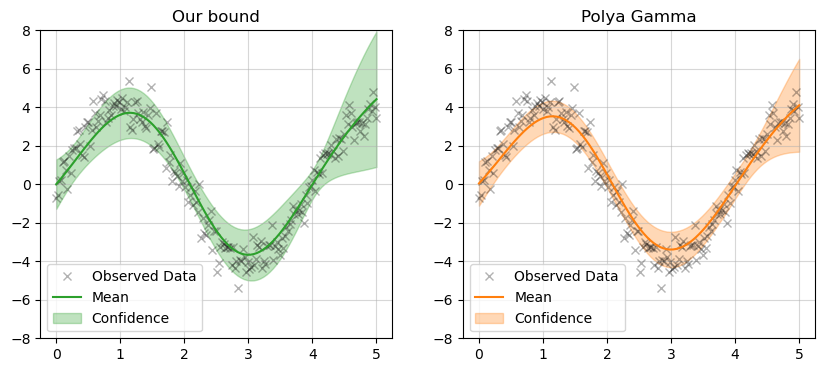

In [90]:
with torch.no_grad():
    _, ax = plt.subplots(1, 2, figsize=(10, 4))

    ax[0].plot(train_x.numpy(), train_f.numpy(), 'kx', alpha=0.3)
    ax[0].plot(test_x.numpy(), f0_pred.numpy(), color='tab:green')
    ax[0].fill_between(test_x.squeeze(1).numpy(), f0_lower.numpy(), f0_upper.numpy(), alpha=0.3, color='tab:green')
    ax[0].set_ylim([-8, 8])
    ax[0].grid(True, alpha=0.5)
    ax[0].set_title("Our bound")

    ax[1].plot(train_x.numpy(), train_f.numpy(), 'kx', alpha=0.3)
    ax[1].plot(test_x.numpy(), f1_pred.numpy(), color='tab:orange')
    ax[1].fill_between(test_x.squeeze(1).numpy(), f1_lower.numpy(), f1_upper.numpy(), alpha=0.3, color='tab:orange')
    ax[1].set_ylim([-8, 8])
    ax[1].grid(True, alpha=0.5)
    ax[1].set_title("Polya Gamma")

    ax[0].legend(['Observed Data', 'Mean', 'Confidence'])
    ax[1].legend(['Observed Data', 'Mean', 'Confidence'])

In [91]:
# pp coverage
f0_lower, f0_upper = f0.credible_intervals(train_x)
f1_lower, f1_upper = f1.credible_intervals(train_x)

print( torch.sum( (train_f > f0_lower) & (train_f < f0_upper) ) / n )
print( torch.sum( (train_f > f1_lower) & (train_f < f1_upper) ) / n )

tensor(0.8650)
tensor(0.7050)
